In [1]:
import numpy
from scipy.special import logsumexp
import matplotlib.pyplot as plt

In [2]:
# Load Data
Xs = numpy.load("mnist_images.npy")
labels = numpy.load("mnist_labels.npy")
Xs = Xs / 255.0

In [3]:
# Constants
N, D = Xs.shape
K = 20 # 0, 1, 2, ..., 9

# To help with debugging:
numpy.random.seed(1000)

# Only run it on a subset of the dataset
N = 500
keys = numpy.random.randint(len(Xs), size=N)
Xs = Xs[keys]
labels = labels[keys]

In [4]:
# Calculate log(eta)

def Estep(Xs, log_p, log_mix_p):
    """
    Xs -- N x D matrix of input data
    log_p -- K x D matrix of log of Bernoulli parameters
    log_mix_p -- K x 1 vector of log of how likely each row of p is

    Note:  This function returns log(eta), not eta for purposes of
    numerical stability.
    """
    log_q = numpy.log(1 - numpy.exp(log_p))
    likelihoods = Xs @ log_p.T + (1 - Xs) @ log_q.T
    denominator = logsumexp(likelihoods, axis=-1)
    log_eta = log_mix_p[None, :] + likelihoods - denominator[:, None]
    return log_eta

In [5]:
def Mstep(Xs, log_eta, alpha1=1e-8, alpha2=1e-8):
    log_sum_etas = logsumexp(log_eta, axis=0) #N1, N2, ... in the homework
    log_sum_etas1 = numpy.logaddexp(log_sum_etas, numpy.log(alpha1 * D)) # Dirichlet smoothing
    log_sum_etas2 = numpy.logaddexp(log_sum_etas, numpy.log(alpha2)) # Dirichlet smoothing
    
    log_p_numerator = logsumexp(log_eta[:, :, None], b=Xs[:, None, :], axis=0)
    log_p_numerator = numpy.logaddexp(log_p_numerator, numpy.log(alpha1)) # Dirichlet smoothing
    log_p = log_p_numerator - log_sum_etas1[:, None]
    
    log_mix_p = log_sum_etas2 - logsumexp(log_sum_etas2)
    
    return (log_p, log_mix_p)

In [6]:
def MoBlabels(Xs, log_p, log_mix_p):
    """
    Return labels for the Xs according to the given log_p and log_mix_p
    """
    log_eta = Estep(Xs, log_p, log_mix_p)
    cluster_labels = numpy.argmax(log_eta, axis=-1)
    return cluster_labels

In [33]:
# Initial guesses

p = numpy.random.rand(K, D)
for i in range(K):
    p[i] /= numpy.dot(p[i], p[i]) ** 0.5
    
mix_p = numpy.ones((K,)) / K

log_p = numpy.log(p)
log_mix_p = numpy.log(mix_p)

In [34]:
# Iterate
for i in range(20):
    log_eta = Estep(Xs, log_p, log_mix_p)
    log_p, log_mix_p = Mstep(Xs, log_eta)

## Analysis

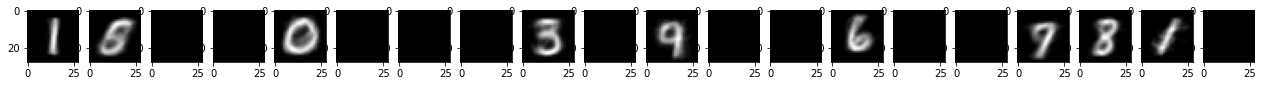

In [35]:
# Show the clusters

fig, ax = plt.subplots(1, K, figsize=(22, 22))
for k in range(K):
    cluster = log_p[k]
    cluster = cluster - numpy.mean(cluster)
    cluster = numpy.exp(cluster)
    cluster = cluster - numpy.min(cluster)
    cluster = cluster / (1e-8 + numpy.max(cluster))
    cluster = cluster.reshape((28, 28))
    ax[k].imshow(cluster, cmap='gray')
plt.show()

I see a lot of digits!  Some of the  digits seem to be combined together, though, and some have multiple copies.  E.g., 4, 7, and 9 collectively form two separate clusters.

In [10]:
# Load Data
all_Xs = numpy.load("mnist_images.npy")
all_labels = numpy.load("mnist_labels.npy")
all_Xs = all_Xs / 255.0

In [ ]:
cluster_labels = MoBlabels(all_Xs, log_p, log_mix_p)

In [ ]:
# Create a K by 10 matrix showing how often each cluster has every label from 0 to 9.
matrix = numpy.zeros((K, 10), dtype=numpy.uint32)

for cluster_label, true_label in zip(cluster_labels, all_labels):
    matrix[cluster_label][true_label] += 1
print(matrix)

In [ ]:
# View matrix visually
matrix = matrix.astype(float)
matrix /= numpy.max(matrix)
plt.imshow(matrix, cmap='gray')
plt.show()

Most clusters have zero numbers.  A few represent a single number (like \#7 which represents a one).  Some are combinations of 2-4 different numbers.